## Initial Setup

In [1]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

In [4]:
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152V2
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils import resample
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization
import sklearn.metrics as m

## Data Pre-Processing

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
base_path = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/images/'
df['img_path'] = base_path + df['image']+'.jpg'
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [7]:
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
df['label'] = df[classes].idxmax(axis=1)
target_counts = {"AKIEC":1200, "BCC":1200, "BKL":1200, "DF":1200, "NV":1200, "MEL":1200, "VASC":1200}
df_balanced = pd.DataFrame(columns=df.columns)

for label, target_count in target_counts.items():
    df_class = df[df['label'] == label]
    current_count = len(df_class)

    if current_count < target_count:
        # Upsample
        df_class_balanced = resample(df_class, replace=True, n_samples=target_count, random_state=42)
    else:
        # Downsample
        df_class_balanced = resample(df_class, replace=False, n_samples=target_count, random_state=42)

    df_balanced = pd.concat([df_balanced, df_class_balanced])

df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipython-input-7-3466899084.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_balanced = pd.concat([df_balanced, df_class_balanced])


In [8]:
total = sum(target_counts.values())
total

8400

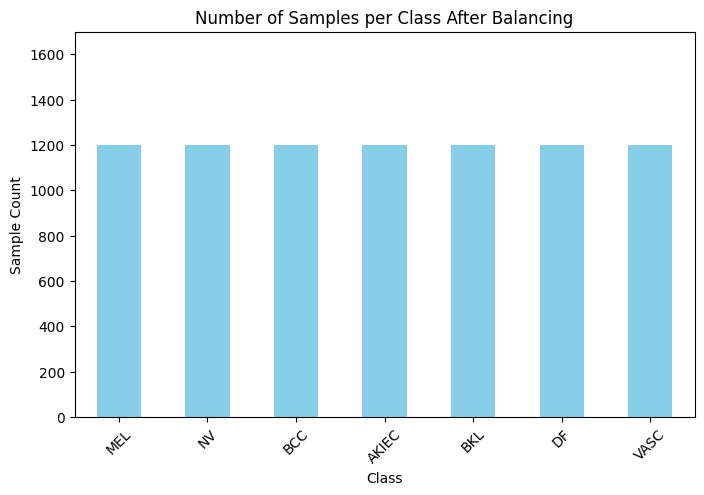

In [10]:
class_counts = df[classes].sum()

# Plot bar chart
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class After Balancing')
plt.ylabel('Sample Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 500)
plt.show()

In [11]:
augmenter = keras.Sequential([
    keras.layers.RandomRotation(factor=0.2),# Data aug: rotation
])

def load_and_preprocess_image(path, label, training=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    if training: # Data aug
        image = augmenter(image)

    image = tf.image.resize(image, [224, 224]) # Image resizing
    image = image / 255.0 # Pixel Normalising
    return image, label

def create_dataset(df, training=False, batch_size=8):
    image_path = df['img_path'].values
    labels = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, training),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if training:
        dataset = dataset.shuffle(512)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create dataset
df_train = create_dataset(df, training=True)

In [12]:
# Capture Ground Truth and transform dataframe for label use

df_validate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
base_path_validate = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/images/'
df_validate['img_path'] = base_path_validate + df_validate['image']+'.jpg'

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
base_path_test = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/images/'
df_test['img_path'] = base_path_test + df_test['image']+'.jpg'

In [13]:
df_validate = create_dataset(df_validate, training=False)
df_test = create_dataset(df_test, training=False)

## Model

In [14]:
def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Model Building and Training


In [15]:
base_model = tf.keras.applications.ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
    )

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1536, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)

x = layers.Dense(384, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(7, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=2.86e-05),
    loss='categorical_crossentropy',
     metrics=['accuracy']
    )

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
start_time = time.time()
histRN152 = model.fit(df_train,epochs=30,validation_data=df_validate,callbacks=[learning_rate_reduction])
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom CNN Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 802s 571ms/step - accuracy: 0.2422 - loss: 2.7289 - val_accuracy: 0.5440 - val_loss: 1.4030 - learning_rate: 2.8600e-05
Epoch 2/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 101s 94ms/step - accuracy: 0.4505 - loss: 1.8369 - val_accuracy: 0.6684 - val_loss: 1.1215 - learning_rate: 2.8600e-05
Epoch 3/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 101s 94ms/step - accuracy: 0.5260 - loss: 1.5991 - val_accuracy: 0.6736 - val_loss: 0.9980 - learning_rate: 2.8600e-05
Epoch 4/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 101s 94ms/step - accuracy: 0.5878 - loss: 1.4100 - val_accuracy: 0.6839 - val_loss: 0.9913 - learning_rate: 2.8600e-05
Epoch 5/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 101s 94ms/step - accuracy: 0.6201 - loss: 1.2342 - val_accuracy: 0.6839 - val_loss: 1.0451 - learning_rate: 2.8600e-05
Epoch 6/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 101s 94ms/step - accuracy: 0.6340 - loss: 1.1679 - val_accuracy: 0.7047 - val_loss: 1.0768 - learning_rate: 2.8600e-05
Epoch 7/30
1050/1050 ━━━━━━━━━━━━

## Model Evaluation

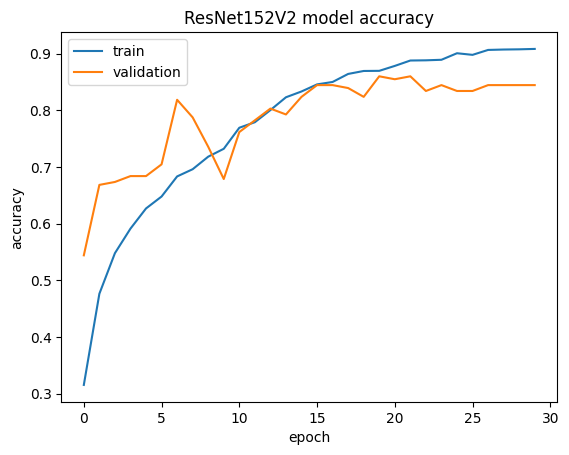

In [17]:
plot_hist(histRN152, "ResNet152V2")

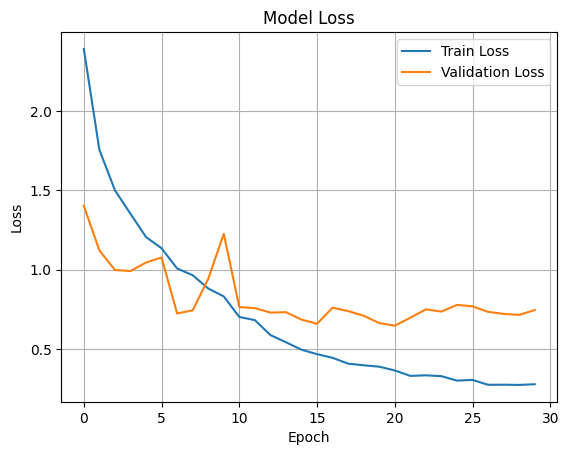

In [18]:
plt.plot(histRN152.history['loss'], label='Train Loss')
plt.plot(histRN152.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


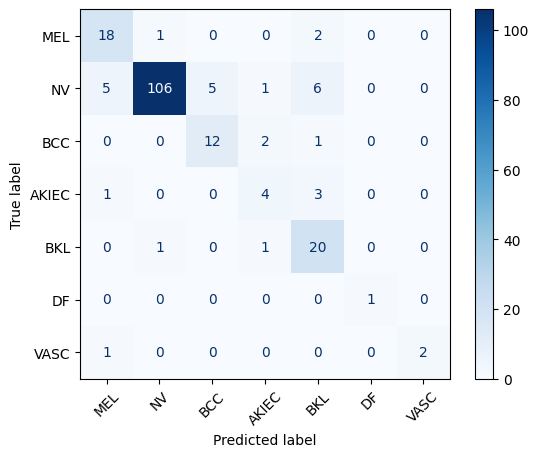

In [19]:
y_true = []
y_pred = []

for images, labels in df_validate:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)

In [20]:
test_loss, *test_metrics = model.evaluate(df_test)
print(f"Test Loss: {test_loss}")
print(f"Test Metrics: {test_metrics}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 113s 594ms/step - accuracy: 0.8026 - loss: 0.7261
Test Loss: 0.8726285099983215
Test Metrics: [0.7685185074806213]


In [21]:
model_save_name = 'modelRN152V2wWeights_BayOp_FinalV2.keras'
path = f"/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/saved_models/{model_save_name}"
model.save(path)

In [27]:
val_preds = model.predict(df_validate)
val_preds_labels = np.argmax(val_preds, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [28]:
val_true_labels = []
for _, labels in df_validate:
    val_true_labels.extend(np.argmax(labels.numpy(), axis=1))
val_true_labels = np.array(val_true_labels)

In [29]:
test_preds = model.predict(df_test)
test_preds_labels = np.argmax(test_preds, axis=1)

test_true_labels = []
for _, labels in df_test:
    test_true_labels.extend(np.argmax(labels.numpy(), axis=1))
test_true_labels = np.array(test_true_labels)

189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


In [30]:
# Validation scores
print("Validation Metrics:")
print(m.classification_report(val_true_labels, val_preds_labels, target_names=classes))

# Test scores
print("Test Metrics:")
print(m.classification_report(test_true_labels, test_preds_labels, target_names=classes))

Validation Metrics:
              precision    recall  f1-score   support

         MEL       0.72      0.86      0.78        21
          NV       0.98      0.86      0.92       123
         BCC       0.71      0.80      0.75        15
       AKIEC       0.50      0.50      0.50         8
         BKL       0.62      0.91      0.74        22
          DF       1.00      1.00      1.00         1
        VASC       1.00      0.67      0.80         3

    accuracy                           0.84       193
   macro avg       0.79      0.80      0.78       193
weighted avg       0.87      0.84      0.85       193

Test Metrics:
              precision    recall  f1-score   support

         MEL       0.49      0.76      0.59       171
          NV       0.94      0.80      0.86       909
         BCC       0.60      0.72      0.66        93
       AKIEC       0.56      0.65      0.60        43
         BKL       0.66      0.69      0.68       217
          DF       0.71      0.73      0.72 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

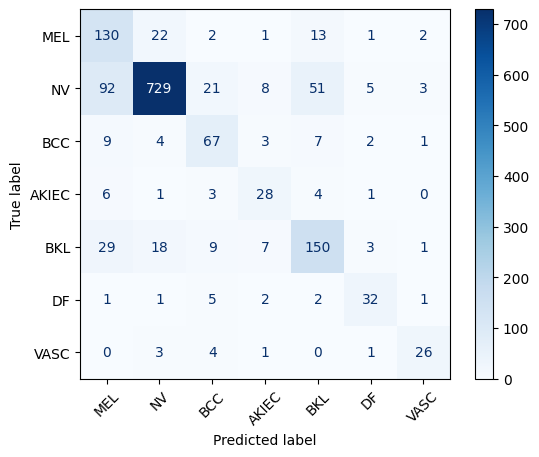

In [31]:
y_true_test = []
y_pred_test = []

for images, labels in df_test:
    preds = model.predict(images)
    y_true_test.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_test.extend(np.argmax(preds, axis=1))

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)